# Random Forest Classifier

In [1]:
!gcloud auth login

Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?code_challenge=zKwO-mNFbFQ32HX8b0hYnFTHcv6gcLzbzLRyaJo2awE&prompt=select_account&code_challenge_method=S256&access_type=offline&redirect_uri=http%3A%2F%2Flocalhost%3A8085%2F&response_type=code&client_id=32555940559.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fappengine.admin+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcompute+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth


If you need to use ADC, see:
  gcloud auth application-default --help

You are now logged in as [galli.giuly@gmail.com].
Your current project is [reddit-master].  You can change this setting by running:
  $ gcloud config set project PROJECT_ID


In [1]:
!gcloud config set project reddit-master

Updated property [core/project].


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle as pkl
import nltk.data
import joblib

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble.forest import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import precision_score, classification_report, confusion_matrix, accuracy_score
from nltk.tokenize import TweetTokenizer

In [2]:
def loggg(msg):
    print("[INFO] {}: {}".format(datetime.datetime.now(), msg))

In [16]:
!gsutil cp gs://reddit_final_results/red_comments_posts_tokenized.pkl .

Copying gs://reddit_final_results/red_comments_posts_tokenized.pkl...
\ [1 files][358.1 MiB/358.1 MiB]    2.6 MiB/s                                   
Operation completed over 1 objects/358.1 MiB.                                    


In [3]:
red_model_RF_df = pd.read_pickle("red_comments_posts_tokenized.pkl")

In [4]:
red_model_RF_df.head()

,subreddit,body,subreddit_id
0,funny,"[hell, job, blue, duck, photo, sourc]",5
1,funny,"[one, settl]",5
2,funny,"[grand, father, fish, cod, like, 50, year, ago]",5
3,funny,"[fake, yes, , effect, real]",5
4,funny,"[smoke, bomb, bug, poison, combin]",5


In [5]:
X = red_model_RF_df['body']
y = red_model_RF_df['subreddit_id']

# Definint a fucntion that slit the dataset into three subsets: train, val and test
def train_dev_test_split(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    return dict(X_train=X_train,
                X_test=X_test,
                y_train=y_train.astype('int'),
                y_test=y_test.astype('int'))

In [6]:
red_model_RF_df_split = train_dev_test_split(X,y)

In [21]:
parameters = {
    #'clf__max_depth': [40, 70, 100],
    #'clf__max_features': ['auto'],
    'clf__n_estimators': [50, 100, 200]
}

In [22]:
%%time

pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(preprocessor=' '.join)),
    ("clf", RandomForestClassifier(min_samples_leaf=30))
])

grid_search_tune = GridSearchCV(pipeline, parameters, cv=2, n_jobs=4, verbose=10)

grid_search_tune.fit(red_model_RF_df_split['X_train'], red_model_RF_df_split['y_train'])

Fitting 2 folds for each of 3 candidates, totalling 6 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   6 | elapsed:  6.1min remaining: 12.2min
[Parallel(n_jobs=4)]: Done   3 out of   6 | elapsed:  9.1min remaining:  9.1min
[Parallel(n_jobs=4)]: Done   4 out of   6 | elapsed: 10.3min remaining:  5.1min
[Parallel(n_jobs=4)]: Done   6 out of   6 | elapsed: 20.1min remaining:    0.0s
[Parallel(n_jobs=4)]: Done   6 out of   6 | elapsed: 20.1min finished


NameError: name 'red_model_rfc' is not defined

In [23]:
grid_search_tune.best_params_

{'clf__n_estimators': 200}

In [24]:
grid_search_tune.best_estimator_

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=<built-in method join of str object at 0x7f0fa463e970>,
                                 smooth_idf=True, stop_words=None,
                                 strip_acce...
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                                        min_impurity_decrea

In [25]:
with open('red_model_rfc.pkl', 'wb') as file:
    pkl.dump(grid_search_tune.best_estimator_, file)

In [ ]:
!gsutil

In [26]:
grid_search_tune.best_score_

0.44588496024941954

In [27]:
with open('red_model_rfc.pkl', 'rb') as file:
    model = pkl.load(file)

predictions = model.predict(red_model_RF_df_split['X_test'])
print(classification_report(red_model_RF_df_split['y_test'], predictions))

              precision    recall  f1-score   support

           0       0.57      0.84      0.68     46567
           1       0.37      0.16      0.22     46567
           2       0.50      0.57      0.53     46567
           3       0.47      0.60      0.53     46097
           4       0.47      0.50      0.49     46567
           5       0.18      0.29      0.22     46567
           6       0.57      0.49      0.53     46567
           7       0.58      0.58      0.58     46568
           8       0.62      0.76      0.68     46567
           9       0.42      0.45      0.43     46257
          10       0.38      0.44      0.40     46125
          11       0.44      0.47      0.45     46164
          12       0.24      0.04      0.07     46093
          13       0.36      0.14      0.20     46098

    accuracy                           0.45    649371
   macro avg       0.44      0.45      0.43    649371
weighted avg       0.44      0.45      0.43    649371



In [36]:
# Uploading the model

!gsutil cp red_model_rfc.pkl gs://reddit_models/

Copying file://red_model_rfc.pkl [Content-Type=application/octet-stream]...
| [1 files][101.0 MiB/101.0 MiB]    4.8 MiB/s                                   
Operation completed over 1 objects/101.0 MiB.                                    


In [2]:
# Downloading the model to test it

!gsutil cp gs://reddit_models/red_model_rfc.pkl .

Copying gs://reddit_models/red_model_rfc.pkl...
/ [1 files][  1.4 KiB/  1.4 KiB]                                                
Operation completed over 1 objects/1.4 KiB.                                      


In [5]:
model = pd.read_pickle("red_model_rfc.pkl")

In [28]:
model

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=<built-in method join of str object at 0x7f0fa463e970>,
                                 smooth_idf=True, stop_words=None,
                                 strip_acce...
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                                        min_impurity_decrea

In [29]:
# needed downloads
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
from nltk.stem.snowball import SnowballStemmer

import re

parser = English()
stemmer = SnowballStemmer(language='english')



# Cleaning the text
## remove urls
def remove_urls(text):
    clean = re.compile(r'http\S+')
    return re.sub(clean, '', str(text))

## remove line endings
def remove_line_endings (text):
    clean = re.compile(r'\n')
    return re.sub(clean, '', str(text))

## remove symbols
def remove_symbols (text):
    clean = re.compile(r"[^a-zA-Z0-9' ]") 
    return re.sub(clean, '', str(text))

def clean_text(text):
    return remove_urls(remove_line_endings(remove_symbols(text.lower())))




# Tokenization and stemming
## tokenization
def tokenize(text):
    return parser(text)

## stopwords
def remove_stopwords(tokenized):
    without_stopwords = []

    for token in tokenized:
        if token.text not in STOP_WORDS:
            without_stopwords.append(token.text)
    return without_stopwords

## stemming
def stem(words):
    stemmed_words = []
    for word in words:
        stemmed_words.append(stemmer.stem(word))
    return stemmed_words

def pre_process (text):
    return stem(remove_stopwords(tokenize(text)))


## Text processing
def text_process (text):
    return pre_process(clean_text(text))

In [30]:
sentence4 = "TIL: This year, the official Yu Gi Oh tournament hosted by Konami instituted a hygiene clause to rulebook. This allows judges to penalize players with dirty clothing or terrible odor by giving them a loss. Super Smash Bros tournament have also started implementing similar rules."

In [31]:
text4 = text_process(sentence4)

text4

['til',
 'year',
 'offici',
 'yu',
 'gi',
 'oh',
 'tournament',
 'host',
 'konami',
 'institut',
 'hygien',
 'claus',
 'rulebook',
 'allow',
 'judg',
 'penal',
 'player',
 'dirti',
 'cloth',
 'terribl',
 'odor',
 'give',
 'loss',
 'super',
 'smash',
 'bros',
 'tournament',
 'start',
 'implement',
 'similar',
 'rule']

In [32]:
result4 = model.predict([text4])

print(result4)

[8]


In [9]:
with open('red_model_rf.pkl', 'rb') as file:
    red_model_rf = pkl.load(file)

y_predicted = red_model_rf.predict(red_model_RF_df_split["X_test"])

In [10]:
accuracy_score(y_predicted, red_model_RF_df_split["y_test"])

0.4522638060523183

# Visualization

In [12]:
conf = confusion_matrix(y_predicted, red_model_RF_df_split['y_test'])

[]

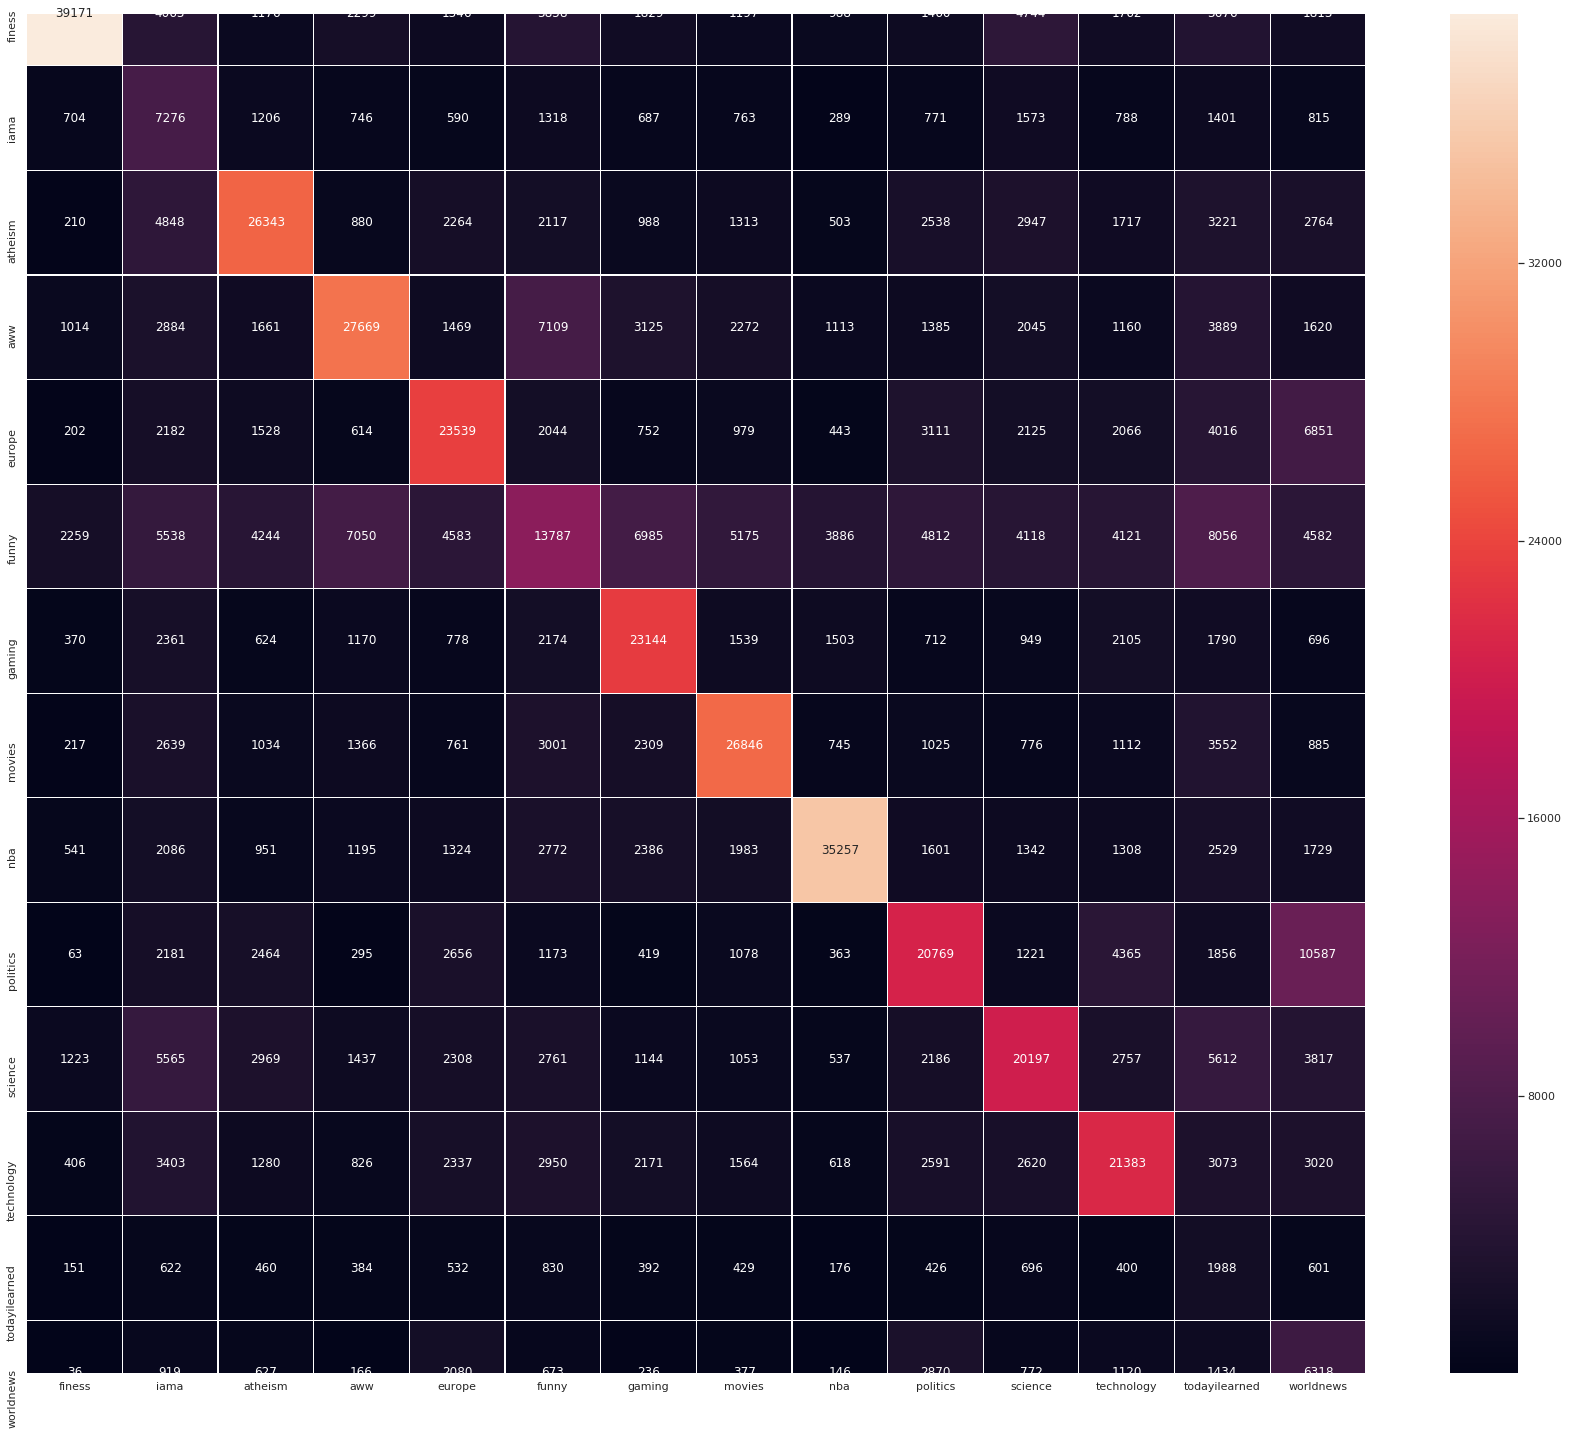

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

subreddits = [
    'finess',
    'iama',
    'atheism',
    'aww',
    'europe',
    'funny',
    'gaming',
    'movies',
    'nba',
    'politics',
    'science',
    'technology',
    'todayilearned',
    'worldnews'
]

plt.figure(figsize =(30, 25))

sns.heatmap(conf, annot=True, linewidths=0.1, fmt='d', xticklabels=subreddits, yticklabels=subreddits)

plt.plot()